In [1]:
!pip -q install pillow ipywidgets tqdm scikit-learn


!pip -q install sentence-transformers || true

import os, zipfile, json, random, time, csv, re
from tqdm import tqdm

os.makedirs("/content/coco", exist_ok=True)
%cd /content/coco

# Download images + annotations (official COCO URLs)
!wget -q -nc http://images.cocodataset.org/zips/val2017.zip
!wget -q -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip
!unzip -q -n val2017.zip
!unzip -q -n annotations_trainval2017.zip

print("Done. Folders:")
!ls -lah
print("\n val2017 sample:")
!ls -lah val2017 | head
print("\n annotations sample:")
!ls -lah annotations | head


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
/content/coco
Done. Folders:
total 1020M
drwxr-xr-x 4 root root 4.0K Feb  2 01:20 .
drwxr-xr-x 1 root root 4.0K Feb  2 01:19 ..
drwxr-xr-x 2 root root 4.0K Feb  2 01:20 annotations
-rw-r--r-- 1 root root 242M Jul 10  2018 annotations_trainval2017.zip
drwxrwxr-x 2 root root 164K Aug 31  2017 val2017
-rw-r--r-- 1 root root 778M Jul 11  2018 val2017.zip

 val2017 sample:
total 788M
drwxrwxr-x 2 root root 164K Aug 31  2017 .
drwxr-xr-x 4 root root 4.0K Feb  2 01:20 ..
-rw-rw-r-- 1 root root 159K Aug 16  2014 000000000139.jpg
-rw-rw-r-- 1 root root 328K Aug 16  2014 000000000285.jpg
-rw-rw-r-- 1 root root 153K Aug 16  2014 000000000632.jpg
-rw-rw-r-- 1 root root 128K Aug 16  2014 000000000724.jpg
-rw-rw-r-- 1 root root 173K Aug 16  2014 000000000776.jpg
-rw-rw-r-- 1 root root 131K Aug 16  2014 000000000785.jpg
-rw-rw-r-- 1 root root  61K Aug 16  2014 000000000802.jpg

 annotations sample:
total 796M
drwxr-xr-x 2 ro

In [2]:
import json, os, re, random
from collections import defaultdict

CAPTIONS_JSON = "/content/coco/annotations/captions_val2017.json"
IMAGES_DIR = "/content/coco/val2017"


INCLUDE_KEYWORDS = [
    "kid", "kids", "child", "children", "baby", "toddler",
    "family", "mother", "father", "parent", "teacher", "school", "classroom", "student",
    "play", "playing", "toy", "ball", "game", "park", "birthday", "party",
    "hug", "smile", "laugh", "talk", "talking", "friends", "friend", "sharing", "share", "help", "helping",
    "drawing", "coloring", "reading", "book"
]

EXCLUDE_KEYWORDS = [
    "gun", "knife", "weapon", "shoot", "shooting", "blood", "kill", "murder", "fight", "fighting",
    "punch", "kick", "war", "bomb", "explosion",
    "beer", "wine", "vodka", "whiskey", "alcohol", "drunk", "smoke", "smoking", "cigarette", "drug",
    "sex", "nude", "naked", "porn", "strip",
    "dead", "corpse", "crime", "robbery", "prison", "terror"
]

def norm(t: str) -> str:
    t = t.lower().strip()
    t = re.sub(r"\s+", " ", t)
    return t

def contains_any(text: str, keywords):
    t = norm(text)
    return any(k in t for k in keywords)

def is_kids_friendly_caption(caption: str) -> bool:
    c = norm(caption)
    if contains_any(c, EXCLUDE_KEYWORDS):
        return False
    if not contains_any(c, INCLUDE_KEYWORDS):
        return False
    return True


with open(CAPTIONS_JSON, "r", encoding="utf-8") as f:
    coco = json.load(f)


caps_by_image = defaultdict(list)
for ann in coco["annotations"]:
    caps_by_image[ann["image_id"]].append(ann["caption"])


file_by_image = {}
for img in coco["images"]:
    file_by_image[img["id"]] = img["file_name"]


filtered = []
for image_id, caps in caps_by_image.items():

    if any(is_kids_friendly_caption(c) for c in caps):
        fn = file_by_image.get(image_id)
        if not fn:
            continue
        path = os.path.join(IMAGES_DIR, fn)
        if os.path.exists(path):
            filtered.append((image_id, path, caps))

print(f"Total COCO val images: {len(file_by_image)}")
print(f"Kids-friendly filtered pool: {len(filtered)}")


random.shuffle(filtered)




Total COCO val images: 5000
Kids-friendly filtered pool: 1748


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

USE_SBERT = False
model = None

try:
    from sentence_transformers import SentenceTransformer
    import numpy as np
    model = SentenceTransformer("all-MiniLM-L6-v2")
    USE_SBERT = True
    print(" Using Sentence-BERT for semantic similarity.")
except Exception:
    USE_SBERT = False
    print("Sentence-BERT not available. Falling back to TF-IDF cosine similarity.")

def _sbert_cosine(a, b):
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def similarity_score(child_text: str, gt_captions: list) -> float:
    """
    Returns score in [0,1].
    We compare child_text to ALL ground-truth captions and take the MAX similarity (fairer).
    """
    child_text = (child_text or "").strip()
    if not child_text:
        return 0.0

    gt_captions = [c.strip() for c in gt_captions if isinstance(c, str) and c.strip()]
    if not gt_captions:
        return 0.0

    if USE_SBERT and model is not None:
        emb = model.encode([child_text] + gt_captions)
        child_emb = emb[0]
        best = 0.0
        for i in range(1, len(emb)):
            cos = _sbert_cosine(child_emb, emb[i])  # [-1, 1]
            score01 = max(0.0, min(1.0, (cos + 1.0) / 2.0))
            best = max(best, score01)
        return float(best)


    texts = [child_text] + gt_captions
    vec = TfidfVectorizer()
    X = vec.fit_transform(texts)
    sims = cosine_similarity(X[0], X[1:])[0]  # [0, 1]
    return float(max(sims)) if len(sims) else 0.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Using Sentence-BERT for semantic similarity.


In [4]:
import os, csv, time
import ipywidgets as widgets
from IPython.display import display
from PIL import Image


LOG_CSV = "/content/coco_kids_context_progress_v2.csv"


CSV_HEADER = [
    "timestamp",
    "child_id",
    "trial_no",
    "image_id",
    "image_path",
    "kid_response",
    "ground_truth_captions",
    "best_similarity_0to1",
    "response_time_sec",
    "processing_latency_ms",
    "method",
    "running_avg_similarity",
    "running_avg_time"
]

if not os.path.exists(LOG_CSV):
    with open(LOG_CSV, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(CSV_HEADER)


def captions_to_string(caps):

    clean = []
    for c in (caps[:5] if caps else []):
        if isinstance(c, str):
            clean.append(c.replace("\n", " ").strip())
    return " || ".join(clean)

def score_band(sim: float) -> str:
    if sim >= 0.80:
        return "Strong match"
    if sim >= 0.60:
        return "Moderate match"
    if sim >= 0.40:
        return "Weak match"
    return "Poor match"

def pil_to_png_bytes(pil_img: Image.Image, max_size=(420, 420)) -> bytes:
    """
    Resize image to a smaller size and return PNG bytes for widgets.Image.
    """
    img = pil_img.copy()
    img.thumbnail(max_size)
    import io
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return buf.getvalue()

state = {
    "child_id": "child_001",
    "trial_no": 0,
    "idx": 0,
    "t_start": None,
    "sum_sim": 0.0,
    "sum_time": 0.0,
}

child_id_box = widgets.Text(
    value="child_001",
    description="Child ID:",
    layout=widgets.Layout(width="220px")
)

start_btn = widgets.Button(description="Start Next Trial", button_style="primary")
submit_btn = widgets.Button(description="Submit Response", button_style="success")
skip_btn = widgets.Button(description="Skip", button_style="warning")

prompt = widgets.HTML("<b>Instruction:</b> Look at the picture and type what is happening.")

text_box = widgets.Textarea(
    value="",
    placeholder="Type your explanation here...",
    description="Response:",
    layout=widgets.Layout(width="900px", height="90px")
)

status = widgets.HTML("")
result = widgets.HTML("")


image_title = widgets.HTML("<b>Picture:</b>")
image_widget = widgets.Image(
    format="png",
    layout=widgets.Layout(max_width="420px", max_height="420px")
)

def load_current_item():
    image_id, path, caps = filtered[state["idx"]]
    pil_img = Image.open(path).convert("RGB")
    return image_id, path, caps, pil_img

def start_trial(_=None):
    if state["idx"] >= len(filtered):
        status.value = "<b>✅ Done:</b> No more filtered images left."
        return

    state["child_id"] = child_id_box.value.strip() or "unknown_child"
    state["trial_no"] += 1
    text_box.value = ""
    result.value = ""

    image_id, path, caps, pil_img = load_current_item()
    image_widget.value = pil_to_png_bytes(pil_img, max_size=(420, 420))

    state["t_start"] = time.time()
    status.value = (
        f"<b>Trial {state['trial_no']}</b> | Image ID: {image_id}<br>"
        f"Timer started. Type response above, then click <b>Submit Response</b>."
    )

def submit_response(_=None):
    if state["t_start"] is None:
        result.value = "<b></b> Click <b>Start Next Trial</b> first."
        return

    image_id, path, caps, _ = load_current_item()
    rt = time.time() - state["t_start"]
    kid = text_box.value.strip()


    t0 = time.perf_counter()
    sim = similarity_score(kid, caps)
    latency_ms = (time.perf_counter() - t0) * 1000

    method = "sbert" if ("USE_SBERT" in globals() and USE_SBERT) else "tfidf"

    state["sum_sim"] += sim
    state["sum_time"] += rt
    avg_sim = state["sum_sim"] / state["trial_no"]
    avg_time = state["sum_time"] / state["trial_no"]

    band = score_band(sim)


    gt_caps_str = captions_to_string(caps)
    gt_html = "<br>".join([f"• {c}" for c in (caps[:5] if caps else [])])


    with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow([
            time.strftime("%Y-%m-%d %H:%M:%S"),
            state["child_id"],
            state["trial_no"],
            image_id,
            path,
            kid,
            gt_caps_str,
            f"{sim:.6f}",
            f"{rt:.4f}",
            f"{latency_ms:.3f}",
            method,
            f"{avg_sim:.6f}",
            f"{avg_time:.6f}",
        ])


    result.value = (
        f"<b>✅ Submitted</b><br>"
        f"Similarity: <b>{sim:.3f}</b> ({band})<br>"
        f"Response time: <b>{rt:.2f}s</b><br>"
        f"Processing latency: <b>{latency_ms:.1f} ms</b><br>"
        f"Running avg similarity: <b>{avg_sim:.3f}</b> | Running avg time: <b>{avg_time:.2f}s</b><br>"
        f"<hr>"
        f"<b>Ground-truth explanations (COCO captions):</b><br>{gt_html}<br>"
        f"<br><i>Saved to:</i> {LOG_CSV}"
    )


    state["idx"] += 1
    state["t_start"] = None

def skip_trial(_=None):
    state["idx"] += 1
    state["t_start"] = None
    result.value = "<b>Skipped.</b> Click <b>Start Next Trial</b> to continue."
    status.value = ""


start_btn.on_click(start_trial)
submit_btn.on_click(submit_response)
skip_btn.on_click(skip_trial)


button_row = widgets.HBox([child_id_box, start_btn, submit_btn, skip_btn])

ui = widgets.VBox([
    button_row,
    prompt,


    text_box,

    image_title,
    image_widget,

    status,
    result
])

display(ui)


#

### Sample graph to analyze response time and interpretation of the above method. The .csv file is in the folder

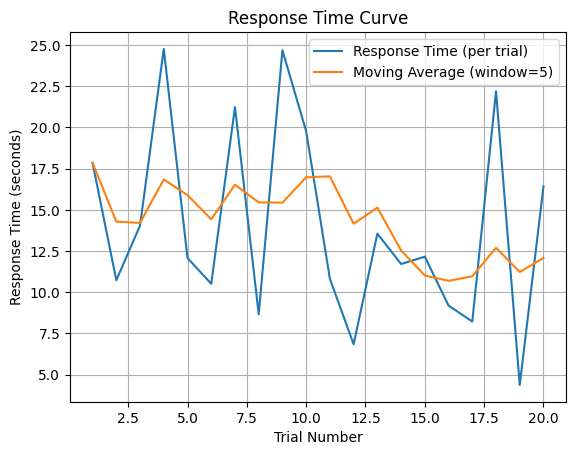

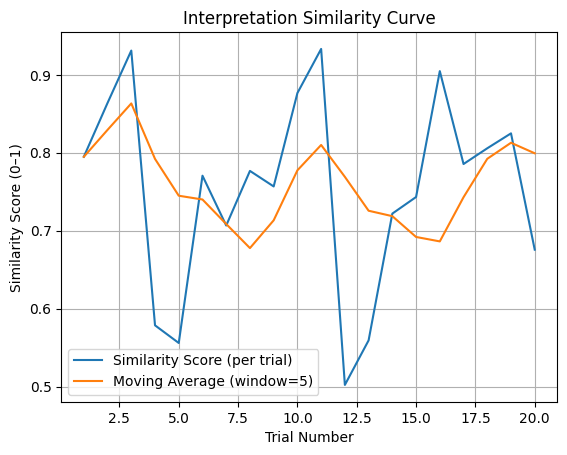

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


CSV_PATH = "/content/coco_kids_context_progress_v2.csv"
df = pd.read_csv(CSV_PATH)

numeric_cols = [
    "trial_no",
    "best_similarity_0to1",
    "response_time_sec"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


df = df.sort_values("trial_no").reset_index(drop=True)


df["trial_index"] = np.arange(1, len(df) + 1)

WINDOW = 5
plt.figure()
plt.plot(
    df["trial_index"],
    df["response_time_sec"],
    label="Response Time (per trial)"
)
plt.plot(
    df["trial_index"],
    df["response_time_sec"].rolling(WINDOW, min_periods=1).mean(),
    label=f"Moving Average (window={WINDOW})"
)

plt.xlabel("Trial Number")
plt.ylabel("Response Time (seconds)")
plt.title("Response Time Curve")
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(
    df["trial_index"],
    df["best_similarity_0to1"],
    label="Similarity Score (per trial)"
)
plt.plot(
    df["trial_index"],
    df["best_similarity_0to1"].rolling(WINDOW, min_periods=1).mean(),
    label=f"Moving Average (window={WINDOW})"
)

plt.xlabel("Trial Number")
plt.ylabel("Similarity Score (0–1)")
plt.title("Interpretation Similarity Curve")
plt.legend()
plt.grid(True)
plt.show()
